<a href="https://colab.research.google.com/github/AdiTiwa/AdiTiwa/blob/main/ansatze_ga.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
try:
    import cirq
    import networkx as nx
except:
    !pip install --quiet cirq networkx
    import cirq
    import networkx as nx

import random as rand
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import numpy.random as npr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.6/45.6 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 27.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.7/532.7 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.3/69.3 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.5/596.5 kB 33.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.5/6.5 MB 89.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 63.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 64.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━

to build genome, we're looking to make a function that can convert a function with a defined mutation function $\mu$ that maps from a type genome to genome, should i create a class? nah bad idea no reason to deal with that lmao. then we use a fitness function $\nu$

lol i made a class

$\mu: G \mapsto G$: what am i supposed to d here lma
uhhhh, make a

In [ ]:
# hyper parameters

MUT_CHANCE = 0.2
EXPLORE = 0.2 # chance to add new gate

GATES = ["Rx", "Ry", "Rz", "CNOT", "RZZ"]

In [ ]:
from collections import Counter
from scipy.stats import unitary_group

def get_circuit_ansatz(qubits):
    """Example ansatz circuit with rotation and entanglement."""
    circuit = cirq.Circuit()
    for q in qubits:
        circuit.append(cirq.rx(np.random.uniform(0, 2*np.pi))(q))
    for i in range(len(qubits) - 1):
        circuit.append(cirq.CNOT(qubits[i], qubits[i+1]))
    return circuit

def get_probabilities_from_circuit(circuit, resolver, num_samples=1000):
    """Run the circuit and return estimated probabilities of bitstrings."""
    simulator = cirq.Simulator()

    resolved_circuit = cirq.resolve_parameters(circuit, resolver)
    result = simulator.run(resolved_circuit, repetitions=num_samples)
    measurements = result.measurements.values()

    # Convert bitstrings to integer indices
    bitstrings = [''.join(map(str, bits)) for bits in zip(*measurements)]

    # Compute empirical probability distribution
    counts = Counter(bitstrings)
    total = sum(counts.values())
    prob_ansatz = {bit: count / total for bit, count in counts.items()}

    return prob_ansatz

def haar_random_distribution(num_qubits):
    """Generate an approximate Haar measure probability distribution."""
    dim = 2**num_qubits
    haar_states = unitary_group.rvs(dim)[:, 0]  # First column of Haar-random unitary
    prob_haar = np.abs(haar_states) ** 2  # Probability distribution
    return prob_haar / np.sum(prob_haar)  # Normalize

def kl_divergence(p_ansatz, p_haar):
    """Compute KL divergence between two distributions."""
    kl_div = 0
    for key, p_a in p_ansatz.items():
        if p_a > 0:  # Avoid log(0)
            kl_div += p_a * np.log(p_a / (p_haar.get(key, 1e-10)))  # Small epsilon for stability
    return kl_div

In [ ]:
class Gate:
    def __init__(self, gate, qubits, parameter):
        """
        :param gate: enum, [Rx, Ry, Rz, CNOT, RZZ]
        :param qubits: tuple (i_0: int,) for gate on qubits i
        :param parameter: p: int U None, parameter to gate given by \theta_p
        :returns None
        """

        self.gates = gate
        self.qubits = qubits
        self.parameter = parameter

    def __str__(self):
        return f"Gate({GATES[self.gates]}, {self.qubits}, {self.parameter})"

    def __copy__(self):
        return Gate(self.gates, self.qubits, self.parameter)

    def __eq__(self, other):
        return id(self) == id(self)

class Gene:
    def __init__(self, gates, n, p: int = None):
        """
        :param gates: Array[Gate] gates in the genome
        :param n: amount of qubits
        :param p: highest number of parameters in the circuit (max param)
        """
        self.gates = gates
        self.n = n

        # find max index parameter in gates
        self.p = max([gate.parameter for gate in gates]) if len(gates) > 0 else 0

    def add_gate(self, g):
        self.gates.append(g)
        self.p = max([gate.parameter for gate in self.gates])

    def to_circuit(self):
        c = cirq.Circuit()
        qubits = cirq.LineQubit.range(self.n)
        X = [sp.Symbol(f'x_{i}') for i in range(self.p + 1)]

        for gate in self.gates:
            qs = [qubits[q] for q in gate.qubits]
            match gate.gates:
                case 0:
                    c.append(cirq.Rx(rads=X[gate.parameter])(*qs))
                case 1:
                    c.append(cirq.Ry(rads=X[gate.parameter])(*qs))
                case 2:
                    c.append(cirq.Rz(rads=X[gate.parameter])(*qs))
                case 3:
                    c.append(cirq.CNOT(*qs))
                case 4:
                    c.append(cirq.ZZ(*qs) ** X[gate.parameter])

        c.append(cirq.measure(*qubits, key='x'))

        return c, X

    def evaluate(self, X): # \nu
        c, params = self.to_circuit()
        resolver = cirq.ParamResolver({params[i]: X[i] for i in range(len(X))})
        prob_ansatz = get_probabilities_from_circuit(c, resolver)

        prob_haar = haar_random_distribution(self.n)
        p_haar = {format(i, f'0{self.n}b'): prob_haar[i] for i in range(2**self.n)}

        return 1 / kl_divergence(prob_ansatz, p_haar)

    def mutate(self): # \mu
        def num_g(r, n = 3):
            import math as m

            sigmoid = lambda x: 1 / (1 + m.exp(-x))
            return m.floor((n + 0.5) * sigmoid(2 * m.e * (r - 0.5)))

        # make a copy to be the next version of this agent
        fut = self.__copy__()

        if npr.choice([True, False], p=[MUT_CHANCE, 1-MUT_CHANCE]):
            # select "gene" to mutate
            if npr.choice([True, False], p=[EXPLORE, 1-EXPLORE]):
                for i in range(num_g(rand.random(), self.n // 2) + 1): # add gates based on shifted sigmoid

                    gate = rand.randint(0, 4)
                    open_qubits = list(range(self.n))
                    q1 = open_qubits.pop(npr.choice(open_qubits))
                    q2 = npr.choice(open_qubits) if gate >= 3 else None

                    qubits = (q1, q2) if gate >= 3 else (q1,)

                    # give it a EXPLORE ** 2 to add a new parameter yk
                    parameter = rand.randint(0, fut.p) if npr.choice([False, True], p=[EXPLORE ** 2, 1 - (EXPLORE ** 2)]) else fut.p + 1

                    fut.add_gate(Gate(
                        gate,
                        qubits,
                        parameter
                    ))
            else:
                nchange=num_g(rand.random(), len(self.gates) // 3) # up to third of gates can be changed

                for _ in range(nchange):
                    gate = npr.choice(self.gates)

                    if npr.choice([False, True], p = [EXPLORE, 1-EXPLORE]):
                        gate.gates = rand.randint(0, 2) if gate.gates <= 2 else rand.randint(3, 4)
                        gate.parameter = rand.randint(0, fut.p) if npr.choice([False, True], p=[EXPLORE ** 2, 1 - (EXPLORE ** 2)]) else fut.p + 1
                    else:
                        self.gates.remove(gate) # womp womp get cooketh

        return fut.__copy__()

    def __str__(self):
        return f'Gene({", ".join([gate.__str__() for gate in self.gates])})'

    def __copy__(self):
        return Gene([g.__copy__() for g in self.gates], self.n, self.p)

In [ ]:
test = Gene([
    Gate(0, (0,), 0),
    Gate(0, (1,), 0),
    Gate(0, (2,), 0)
], 3)

In [ ]:
test.to_circuit()

adding Gate(Rx, (0,), 0)
[cirq.LineQubit(0)]
adding Gate(Rx, (1,), 0)
[cirq.LineQubit(1)]
adding Gate(Rx, (2,), 0)
[cirq.LineQubit(2)]


(0: ───Rx(x_0)───

1: ───Rx(x_0)───

2: ───Rx(x_0)───, [x_0])

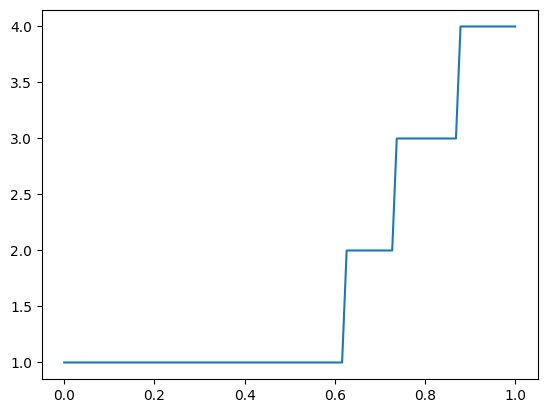

In [ ]:
def num_g(r, n = 3, s=2):
    import math as m

    sigmoid = lambda x: 1 / (1 + m.exp(-x))
    return m.floor((n + 0.5) * sigmoid(s * m.e * (r - ((0.25) ** (1/s)))) + 1)

# generate a plot for num_g
x = np.linspace(0, 1, 100)
y = [num_g(i, s=4) for i in x]
plt.plot(x, y)
plt.show()

# verify that added gates don't exceed 3 lmao
for _ in range(10000):
    assert len(test.mutate().gates) - len(test.gates) <= 4

In [ ]:
mutated = test.mutate()
while len(mutated.gates) == len(test.gates):
    mutated = test.mutate()

mutated.to_circuit()

(                ┌─────────────┐
0: ───Rx(x_0)────ZZ───────────────Rx(x_0)───M('x')───
                 │                          │
1: ───Rx(x_0)────┼─────Rx(x_0)──────────────M────────
                 │                          │
2: ───Rx(x_0)────ZZ^x_0─────────────────────M────────
                └─────────────┘,
 [x_0])

In [ ]:
for _ in range(10):
    X = [0.1 * np.pi for _ in range(mutated.p + 1)]
    print(f"kl-divergence: {mutated.evaluate(X)} for X: {X}")
    mutated = mutated.mutate()

kl-divergence: 22.181624592186623 for X: [0.3141592653589793]
kl-divergence: 22.171235004507693 for X: [0.3141592653589793]
kl-divergence: 22.137724512487548 for X: [0.3141592653589793]
kl-divergence: 22.07332806789243 for X: [0.3141592653589793]
kl-divergence: 22.178967692492062 for X: [0.3141592653589793]
kl-divergence: 22.135780222192416 for X: [0.3141592653589793]
kl-divergence: 22.184684357039004 for X: [0.3141592653589793]
kl-divergence: 22.126569047245113 for X: [0.3141592653589793]
kl-divergence: 22.104942683856212 for X: [0.3141592653589793]
kl-divergence: 22.00916898080665 for X: [0.3141592653589793]


In [ ]:
mutated.to_circuit()

(                ┌─────────────┐
0: ───Rx(x_0)────ZZ───────────────Rx(x_0)───ZZ───────ZZ───────Rz(x_0)───ZZ───────Ry(x_0)──────────────────────────M('x')───
                 │                          │        │                  │                                         │
1: ───Rx(x_0)────┼─────Rx(x_0)────Rx(x_0)───┼────────┼──────────────────ZZ^x_0───@─────────Ry(x_0)───ZZ───────X───M────────
                 │                          │        │                           │                   │        │   │
2: ───Rx(x_0)────ZZ^x_0─────────────────────ZZ^x_0───ZZ^x_0──────────────────────X───────────────────ZZ^x_0───@───M────────
                └─────────────┘,
 [x_0])

oka let's give it a shot

In [ ]:
# new hyperparameters
GEN_SIZE = 100
EPOCHS = 15
QUBITS = 5

PERCENTAGE = 0.2 # gen size should be divisible by percentage bc

In [ ]:
current_generation = []
for _ in range(GEN_SIZE):
    g = Gene([], QUBITS)

    for _ in range(num_g(rand.random(), QUBITS // 2, s=4)):
        gate = rand.randint(0, 4)
        open_qubits = list(range(QUBITS))
        q1 = open_qubits.pop(npr.choice(open_qubits))
        q2 = npr.choice(open_qubits) if gate >= 3 else None

        qubits = (q1, q2) if gate >= 3 else (q1,)

        # give it a EXPLORE ** 2 to add a new parameter yk
        parameter = rand.randint(0, g.p) if npr.choice([False, True], p=[EXPLORE ** 2, 1 - (EXPLORE ** 2)]) else g.p + 1

        g.add_gate(Gate(
            gate,
            qubits,
            parameter
        ))

    current_generation.append(g)

In [ ]:
for gene in current_generation:
    print(gene) # making sure something doesn't look completely stupid here

Gene(Gate(Rz, (4,), 0))
Gene(Gate(Rz, (5,), 0))
Gene(Gate(RZZ, (0, 4), 0), Gate(Rx, (6,), 0), Gate(Rx, (3,), 0), Gate(Ry, (4,), 0), Gate(RZZ, (9, 3), 0), Gate(CNOT, (2, 7), 0))
Gene(Gate(RZZ, (8, 7), 0), Gate(Ry, (7,), 0), Gate(CNOT, (8, 1), 1), Gate(Rz, (9,), 1), Gate(CNOT, (7, 6), 0))
Gene(Gate(CNOT, (1, 2), 0))
Gene(Gate(Rz, (9,), 0))
Gene(Gate(Ry, (0,), 0), Gate(Rz, (8,), 0), Gate(Rz, (6,), 0), Gate(Rx, (2,), 0))
Gene(Gate(CNOT, (7, 9), 0), Gate(CNOT, (4, 6), 0), Gate(Rx, (9,), 0), Gate(RZZ, (9, 3), 0), Gate(Rx, (3,), 0))
Gene(Gate(RZZ, (4, 1), 0), Gate(Ry, (8,), 0), Gate(Rx, (5,), 0), Gate(RZZ, (0, 6), 0), Gate(CNOT, (0, 7), 0), Gate(Rz, (2,), 0))
Gene(Gate(RZZ, (8, 2), 0))
Gene(Gate(CNOT, (7, 5), 0))
Gene(Gate(Rz, (9,), 0), Gate(RZZ, (1, 2), 0), Gate(RZZ, (1, 8), 0), Gate(CNOT, (9, 5), 0), Gate(Rx, (3,), 0))
Gene(Gate(Rx, (2,), 0), Gate(CNOT, (7, 0), 0), Gate(Rx, (9,), 0), Gate(RZZ, (1, 8), 0))
Gene(Gate(RZZ, (6, 3), 0))
Gene(Gate(RZZ, (0, 8), 0))
Gene(Gate(Rz, (3,), 0), Gate(CNO

In [ ]:
for epoch in range(EPOCHS):
    if epoch % 2 == 0:
        print(f"Epoch {epoch}:")
        print(f"==============")

    total_fitness = []
    for ngene in range(len(current_generation)):
        total_fitness.append(current_generation[ngene].evaluate([0.1 * np.pi for _ in range(current_generation[ngene].p + 1)]))
        if ngene % (GEN_SIZE // 5) == 0 and epoch % 2 == 0:
            print(f'calculated fitness for gene {ngene}.')

    combined_array = zip(current_generation, total_fitness)
    sorted_array = sorted(combined_array, key=lambda x: x[1])

    if epoch % 2 == 0:
        print(f"Max fitness is: ({sorted_array[-1][0]}, {sorted_array[-1][1]})")

    # select PERCENTAGE% of current_generation with highest fitness
    selected = [x[0] for x in sorted_array[int(-PERCENTAGE* GEN_SIZE):]]

    current_generation.clear() # yay

    for gene in selected: # aw :(
        for _ in range(int(GEN_SIZE / (PERCENTAGE * 100))):
            current_generation.append(gene.mutate())

Epoch 0:
calculated fitness for gene 0.
calculated fitness for gene 20.
calculated fitness for gene 40.
calculated fitness for gene 60.
calculated fitness for gene 80.
Max fitness is: (Gene(Gate(RZZ, (4, 1), 0), Gate(Rx, (3,), 0), Gate(Rx, (1,), 0)), 0.043974803405644185)
Epoch 2:
calculated fitness for gene 0.
calculated fitness for gene 20.
calculated fitness for gene 40.
calculated fitness for gene 60.
calculated fitness for gene 80.
Max fitness is: (Gene(Gate(RZZ, (4, 1), 0), Gate(Rx, (3,), 0), Gate(Rx, (1,), 0), Gate(CNOT, (4, 3), 0), Gate(Ry, (0,), 0)), 0.04404130625158031)
Max fitness is: (Gene(Gate(Rx, (4,), 0), Gate(Rx, (0,), 0), Gate(Ry, (2,), 0)), 0.04421022130793473)
Epoch 4:
calculated fitness for gene 0.
calculated fitness for gene 20.
calculated fitness for gene 40.
calculated fitness for gene 60.
calculated fitness for gene 80.
Max fitness is: (Gene(Gate(RZZ, (4, 1), 0), Gate(Rx, (3,), 0), Gate(Rx, (1,), 0), Gate(CNOT, (4, 3), 0), Gate(Ry, (0,), 0), Gate(Ry, (0,), 1), G